# Project Overview

## Import Libraries

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## Business Case/Problem

## Data Description

## Data Load

In [28]:
df = pd.read_csv('data/kc_house_data.csv')

In [31]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

Features to remove: 
- 'yr_renovated': large number of missing data.

## Split Data into Training and Test set

In [36]:
target = df['price']
features = df.drop(['price'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(features,target,test_size=0.3,random_state=42)
x_train

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
753,8682300890,8/28/2014,2,2.50,2380,6600,1.0,NaN,0.0,3,8,2380,0.0,2010,NaN,98053,47.7170,-122.020,1870,6600
1418,8073000550,4/15/2015,4,3.75,3190,17186,2.0,1.0,4.0,3,10,3190,0.0,1999,0.0,98178,47.5115,-122.246,2290,13496
8178,7212680850,9/3/2014,3,2.50,1730,6930,2.0,0.0,0.0,3,8,1730,0.0,1994,0.0,98003,47.2621,-122.308,1780,6930
2254,8880600070,11/12/2014,4,2.00,1870,8750,1.0,0.0,2.0,3,7,1870,0.0,1977,0.0,98022,47.1985,-122.001,1770,8207
4063,7226500100,2/19/2015,8,3.00,2850,12714,1.0,NaN,0.0,3,7,2850,0.0,1959,0.0,98055,47.4859,-122.205,1480,4942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,7853230570,9/15/2014,3,2.50,2230,5800,2.0,0.0,0.0,3,7,2230,0.0,2004,0.0,98065,47.5308,-121.847,2230,6088
21575,4140940150,10/2/2014,4,2.75,2770,3852,2.0,0.0,0.0,3,8,2770,0.0,2014,NaN,98178,47.5001,-122.232,1810,5641
5390,8658300480,7/21/2014,4,1.50,1530,9000,1.0,0.0,0.0,4,6,1530,0.0,1976,0.0,98014,47.6492,-121.908,1520,8500
860,1723049033,6/20/2014,1,0.75,380,15000,1.0,0.0,0.0,3,5,380,0.0,1963,0.0,98168,47.4810,-122.323,1170,15000


## Data Cleaning

Let's review columns to see which ones make the most sense to keep.

In [37]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [55]:
columns_to_keep = ['bedrooms', 
                   'bathrooms', 
                   'sqft_living', 
                   'sqft_lot', 
                   'floors', 
                   'condition',
                  'grade',
                  'sqft_above',
                  'sqft_basement',
                  'yr_built',
                  'zipcode'
                  ]

In [54]:
def filter_columns(df):
    columns_to_keep = ['bedrooms', 
                   'bathrooms', 
                   'sqft_living', 
                   'sqft_lot', 
                   'floors', 
                   'condition',
                  'grade',
                  'sqft_above',
                  'yr_built',
                  'zipcode'
                  ]
    return df[columns_to_keep]

In [63]:
df_filtered = filter_columns(x_train)
df_filtered.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,zipcode
753,2,2.50,2380,6600,1.0,3,8,2380,2010,98053
1418,4,3.75,3190,17186,2.0,3,10,3190,1999,98178
8178,3,2.50,1730,6930,2.0,3,8,1730,1994,98003
2254,4,2.00,1870,8750,1.0,3,7,1870,1977,98022
4063,8,3.00,2850,12714,1.0,3,7,2850,1959,98055


In [64]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15117 entries, 753 to 15795
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedrooms     15117 non-null  int64  
 1   bathrooms    15117 non-null  float64
 2   sqft_living  15117 non-null  int64  
 3   sqft_lot     15117 non-null  int64  
 4   floors       15117 non-null  float64
 5   condition    15117 non-null  int64  
 6   grade        15117 non-null  int64  
 7   sqft_above   15117 non-null  int64  
 8   yr_built     15117 non-null  int64  
 9   zipcode      15117 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.3 MB


Missing data from 'waterfront' column will need to be addressed.

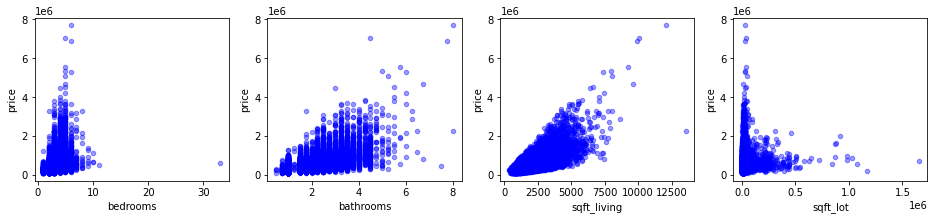

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['bedrooms', 
                     'bathrooms',
                     'sqft_living',
                     'sqft_lot', 
                     ], axes):
    df_filtered.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

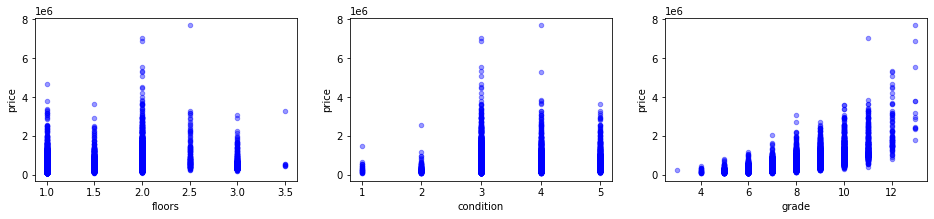

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))

for xcol, ax in zip(['floors',
                     'condition',
                     'grade'], axes):
    df_filtered.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

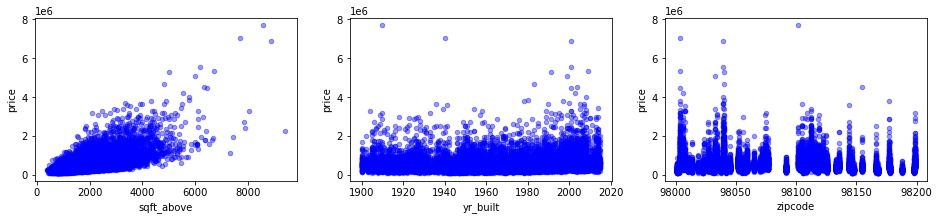

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))

for xcol, ax in zip(['sqft_above',
                    'yr_built',
                    'zipcode'], axes):
    df_filtered.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

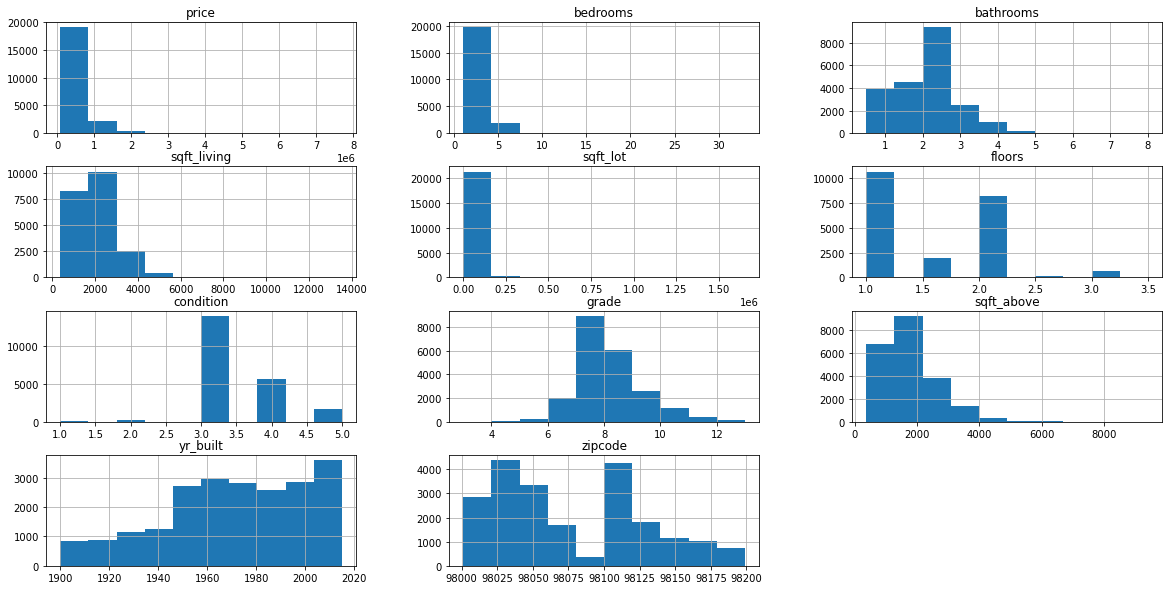

In [45]:
import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize = (20,10))
ax = fig.gca()
df_filtered.hist(ax = ax);

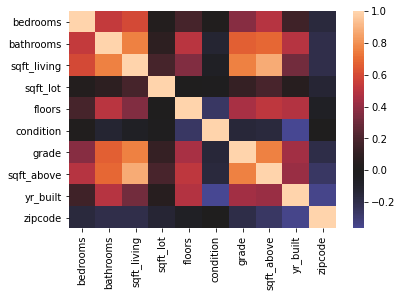

In [66]:
sns.heatmap(df_filtered.corr(), center=0);

In [46]:
df_filtered['yr_built'] = house_data_filtered['yr_built'].astype('str')
df_filtered['zipcode'] = house_data_filtered['zipcode'].astype('str')

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21597 non-null  float64
 1   bedrooms     21597 non-null  int64  
 2   bathrooms    21597 non-null  float64
 3   sqft_living  21597 non-null  int64  
 4   sqft_lot     21597 non-null  int64  
 5   floors       21597 non-null  float64
 6   condition    21597 non-null  int64  
 7   grade        21597 non-null  int64  
 8   sqft_above   21597 non-null  int64  
 9   yr_built     21597 non-null  object 
 10  zipcode      21597 non-null  object 
dtypes: float64(3), int64(6), object(2)
memory usage: 1.8+ MB


In [48]:
df_filtered.zipcode.unique()

array(['98178', '98125', '98028', '98136', '98074', '98053', '98003',
       '98198', '98146', '98038', '98007', '98115', '98107', '98126',
       '98019', '98103', '98002', '98133', '98040', '98092', '98030',
       '98119', '98112', '98052', '98027', '98117', '98058', '98001',
       '98056', '98166', '98023', '98070', '98148', '98105', '98042',
       '98008', '98059', '98122', '98144', '98004', '98005', '98034',
       '98075', '98116', '98010', '98118', '98199', '98032', '98045',
       '98102', '98077', '98108', '98168', '98177', '98065', '98029',
       '98006', '98109', '98022', '98033', '98155', '98024', '98011',
       '98031', '98106', '98072', '98188', '98014', '98055', '98039'],
      dtype=object)

In [49]:
df_filtered.yr_built.unique()

array(['1955', '1951', '1933', '1965', '1987', '2001', '1995', '1963',
       '1960', '2003', '1942', '1927', '1977', '1900', '1979', '1994',
       '1916', '1921', '1969', '1947', '1968', '1985', '1941', '1915',
       '1909', '1948', '2005', '1929', '1981', '1930', '1904', '1996',
       '2000', '1984', '2014', '1922', '1959', '1966', '1953', '1950',
       '2008', '1991', '1954', '1973', '1925', '1989', '1972', '1986',
       '1956', '2002', '1992', '1964', '1952', '1961', '2006', '1988',
       '1962', '1939', '1946', '1967', '1975', '1980', '1910', '1983',
       '1978', '1905', '1971', '2010', '1945', '1924', '1990', '1914',
       '1926', '2004', '1923', '2007', '1976', '1949', '1999', '1901',
       '1993', '1920', '1997', '1943', '1957', '1940', '1918', '1928',
       '1974', '1911', '1936', '1937', '1982', '1908', '1931', '1998',
       '1913', '2013', '1907', '1958', '2012', '1912', '2011', '1917',
       '1932', '1944', '1902', '2009', '1903', '1970', '2015', '1934',
      

In [57]:
zip_dummies = pd.get_dummies(df_filtered['zipcode'], prefix='zip', drop_first=True)
yr_dummies = pd.get_dummies(df_filtered['yr_built'], prefix='yr', drop_first=True)

In [ ]:
df_dummies = df_filtered.drop(['zipcode','yr_built'], axis=1)

In [67]:
df_dummies = pd.concat([df_filtered, zip_dummies, yr_dummies], axis=1)
df_dummies.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,zipcode,...,yr_2006,yr_2007,yr_2008,yr_2009,yr_2010,yr_2011,yr_2012,yr_2013,yr_2014,yr_2015
753,2,2.50,2380,6600,1.0,3,8,2380,2010,98053,...,0,0,0,0,1,0,0,0,0,0
1418,4,3.75,3190,17186,2.0,3,10,3190,1999,98178,...,0,0,0,0,0,0,0,0,0,0
8178,3,2.50,1730,6930,2.0,3,8,1730,1994,98003,...,0,0,0,0,0,0,0,0,0,0
2254,4,2.00,1870,8750,1.0,3,7,1870,1977,98022,...,0,0,0,0,0,0,0,0,0,0
4063,8,3.00,2850,12714,1.0,3,7,2850,1959,98055,...,0,0,0,0,0,0,0,0,0,0


## Model A

## Feature Engineering

## Model Training

## Model Evaluation

## Conclusions/Summary